In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Change default colours to personal colour scheme
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["indianred", "cornflowerblue", "mediumseagreen", "plum", "sandybrown"]) 

rootPath = r"/home/daraghhollman/Main/UCD_PASS_Labs/RamsauerTownsend/Data"

def LoadFile(path, skiprows=2):
    data = np.array(np.loadtxt(path, skiprows=skiprows))
    return data

In [3]:
def Current(voltage, resistance):
    return voltage / resistance

In [4]:
def ExtractData(data, uncertainnty=False):
    inputVoltage = data[:,0]
    plateCurrent = [Current(el/1000, 10000) for el in data[:,1]] # note conversion from milivolts to volts
    shieldCurrent = [Current(el/1000, 100) for el in data[:,2]]    

    if uncertainnty:
        plateCurrentUncertainty = [Current(0.05/1000, 10000) for el in data[:,3]]  
        return [inputVoltage, plateCurrent, shieldCurrent, plateCurrentUncertainty]
    else:
        return [inputVoltage, plateCurrent, shieldCurrent]

Text(0, 0.5, 'Plate Current (A)')

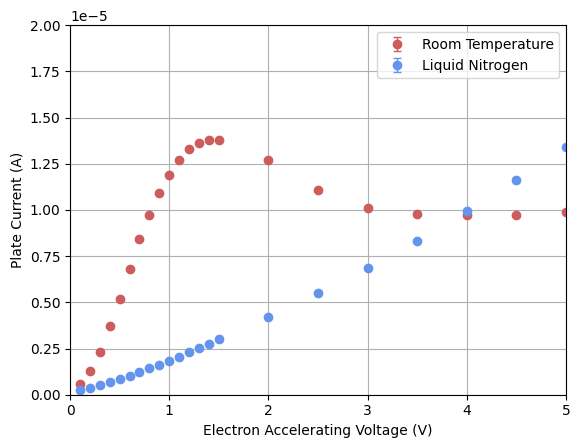

In [5]:
warmData = ExtractData(LoadFile(rootPath + r"/warmDataLess.txt"), uncertainnty=True)

coldData = ExtractData(LoadFile(rootPath + r"/coldData.txt"), uncertainnty=False)

plt.errorbar(warmData[0], [el*10 for el in warmData[1]], yerr=warmData[3], fmt="o", capsize=3, linewidth=1, label="Room Temperature")
plt.errorbar(coldData[0], coldData[1], yerr=Current(0.05/1000, 10000), fmt="o", capsize=3, linewidth=1, label="Liquid Nitrogen")

plt.legend()
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 2e-5)
plt.xlabel("Electron Accelerating Voltage (V)")
plt.ylabel("Plate Current (A)")

In [6]:
def ProbabilityOfScattering(warmIp, warmIs, coldIp, coldIs):
    return 1 - warmIp * coldIs / (warmIs * coldIp)

def dPdWIp(warmIp, warmIs, coldIp, coldIs):
    return - coldIs / (warmIs * coldIp)

def dPdWIs(warmIp, warmIs, coldIp, coldIs):
    return warmIp * coldIs / (warmIs**2 * coldIp)

def dPdCIp(warmIp, warmIs, coldIp, coldIs):
    return warmIp * coldIs / (warmIs * coldIp**2)

def dPdCIs(warmIp, warmIs, coldIp, coldIs):
    return - warmIp / (warmIs * coldIp)

def ProbabilityOfScatteringUncertainty(warmIp, warmIs, coldIp, coldIs, uWarmIp, uWarmIs, uColdIp, uColdIs):
    
    warmIpContribution = dPdWIp(warmIp, warmIs, coldIp, coldIs)**2 * uWarmIp**2
    warmIsContribution = dPdWIs(warmIp, warmIs, coldIp, coldIs)**2 * uWarmIs**2
    coldIpContribution = dPdCIp(warmIp, warmIs, coldIp, coldIs)**2 * uColdIp**2
    coldIsContribution = dPdCIs(warmIp, warmIs, coldIp, coldIs)**2 * uColdIs**2
    
    return np.sqrt(warmIpContribution + warmIsContribution + coldIpContribution + coldIsContribution)

def dIdV(R):
    return 1/R

def CurrentUncertainty(uV, R):
    return np.sqrt(dIdV(R)**2 * uV**2)

In [22]:
plateVoltageLists = [warmData[1], coldData[1]]
shieldVoltageLists = [warmData[2], coldData[2]]

plateCurrentLists = []
for list in plateVoltageLists:
    newCurrentList = []
    for voltage in list:
        newCurrentList.append(Current(voltage, 10000))
    plateCurrentLists.append(newCurrentList)

shieldCurrentLists = []
for list in shieldVoltageLists:
    newCurrentList = []
    for voltage in list:
        newCurrentList.append(Current(voltage, 100))
    shieldCurrentLists.append(newCurrentList)

probabilityOfScattering = [ProbabilityOfScattering(a, b, c, d) \
    for a, b, c, d in zip(plateCurrentLists[0], shieldCurrentLists[0], plateCurrentLists[1], shieldCurrentLists[1])]

warmShieldVoltageError = []
for i in range(len(warmData[2])):
    if warmData[2][i] < 200/1000:
        warmShieldVoltageError.append(0.05/1000)
    elif warmData[2][i] > 200/1000:
        warmShieldVoltageError.append(0.5/1000)

coldShieldVoltageError = []
for i in range(len(coldData[2])):
    if coldData[2][i] < 200:
        coldShieldVoltageError.append(0.05/1000)
    elif coldData[2][i] > 200:
        coldShieldVoltageError.append(0.5/1000)

probabilityOfScatteringUncertainty = []
for warmIp, warmIs, coldIp, coldIs, uWarmIp, uWarmIs, uColdIp, uColdIs in zip(plateCurrentLists[0], \
    shieldCurrentLists[0], plateCurrentLists[1], shieldCurrentLists[1], \
        [CurrentUncertainty(0.05/1000, 10000)]*len(plateCurrentLists[0]), \
        [CurrentUncertainty(uV, 100) for uV in warmShieldVoltageError], \
            [CurrentUncertainty(0.05/1000, 10000)]*len(plateCurrentLists[0]), \
            [CurrentUncertainty(uV, 100) for uV in coldShieldVoltageError]):

    probabilityOfScatteringUncertainty.append(\
        ProbabilityOfScatteringUncertainty(warmIp, warmIs, coldIp, coldIs, uWarmIp, uWarmIs, uColdIp, uColdIs))

print(probabilityOfScatteringUncertainty)
probabilityOfScatteringUncertainty = [el/10000 for el in probabilityOfScatteringUncertainty]

[431.9289149848619, 252.5157400027043, 169.58129208652815, 122.83559315840829, 94.68138126811247, 76.01240056729162, 62.505310648180185, 52.46985201923111, 44.74463634535257, 38.095797486444965, 33.17852604257133, 29.025188399706074, 25.528922932959098, 22.754087941288464, 20.468115656736533, 13.547138748092992, 10.09115224738238, 8.000144895217508, 6.577475278420045, 5.57813835677166, 4.807737777535432, 4.212666880320136, 3.7342773839934065, 3.3660041689175566, 3.086644132642144, 2.849764657974558, 2.641193438687383, 2.4296813283876197, 2.2496255794021005, 2.0842950651428516, 1.936576219360492, 1.827656714480186, 1.7453829559190897, 1.6776639942688392, 1.5829601627239867, 1.4542950453929377, 1.2765219351608958, 1.1894341574327283, 1.451619884551446, 1.6440654576782265, 1.2261232482605633, 0.9450554210838951]


In [23]:
print(CurrentUncertainty(0.05, 10000))

5e-06


Text(0, 0.5, 'Probability of Scattering')

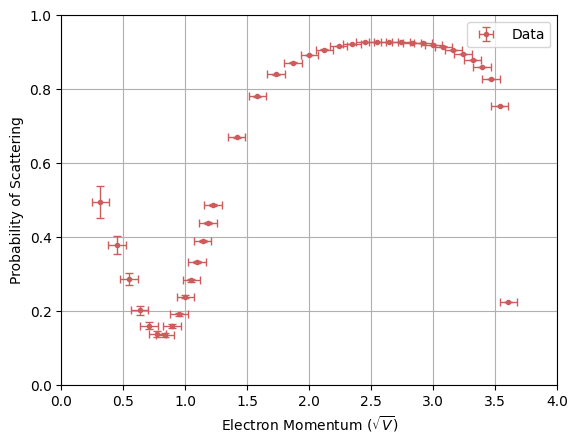

In [25]:
plt.errorbar([np.sqrt(el) for el in warmData[0]], probabilityOfScattering, xerr=np.sqrt(0.005), yerr=probabilityOfScatteringUncertainty, fmt=".", capsize=3, linewidth=1, label="Data")

plt.legend()
plt.grid()
plt.xlim(0, 4)
plt.ylim(0, 1)
plt.xlabel("Electron Momentum ($\sqrt{V}$)")
plt.ylabel("Probability of Scattering")

Text(0, 0.5, 'Scattering Cross-Section')

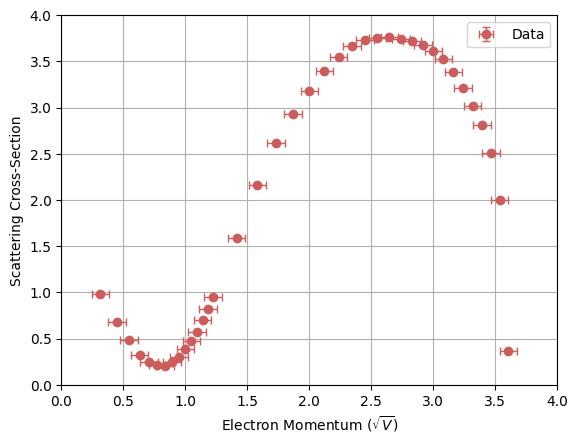

In [35]:
def DensityCrossSection(probabilityOfScattering):
    return - np.log(1 - probabilityOfScattering) / 0.7

plt.errorbar([np.sqrt(el) for el in warmData[0]], [DensityCrossSection(el) for el in probabilityOfScattering], xerr=np.sqrt(0.005), yerr=0, fmt="o", capsize=3, linewidth=1, label="Data")

plt.legend()
plt.grid()
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xlabel("Electron Momentum ($\sqrt{V}$)")
plt.ylabel("Scattering Cross-Section")